# Exploration Notebook

This notebook is used for exploratory data analysis and experimentation with the TREC dataset for topic classification using an RNN model.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import os

# Download TREC dataset manually
def download_trec():
    base_url = "https://cogcomp.seas.upenn.edu/Data/QA/QC/"
    files = {
        'train_5500.label': 'train',
        'TREC_10.label': 'test'
    }
    
    for filename in files.keys():
        if not os.path.exists(filename):
            print(f"Downloading {filename}...")
            urllib.request.urlretrieve(base_url + filename, filename)
    
    return files

# Parse TREC format: "LABEL:sublabel question text"
def parse_trec_file(filepath):
    texts = []
    labels = []
    with open(filepath, 'r', encoding='latin-1') as f:
        for line in f:
            if line.strip():
                parts = line.strip().split(' ', 1)
                if len(parts) == 2:
                    label, text = parts
                    coarse_label = label.split(':')[0]
                    texts.append(text)
                    labels.append(coarse_label)
    return pd.DataFrame({'text': texts, 'label': labels})

# Download and load data
files = download_trec()
train_df = parse_trec_file('train_5500.label')
test_df = parse_trec_file('TREC_10.label')

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")
print(f"\nLabel distribution:\n{train_df['label'].value_counts()}")

# Display the first few rows of the training data
train_df.head()

Train size: 5452
Test size: 500

Label distribution:
label
ENTY    1250
HUM     1223
DESC    1162
NUM      896
LOC      835
ABBR      86
Name: count, dtype: int64


,text,label
0,How did serfdom develop in and then leave Russ...,DESC
1,What films featured the character Popeye Doyle ?,ENTY
2,How can I find a list of celebrities ' real na...,DESC
3,What fowl grabs the spotlight after the Chines...,ENTY
4,What is the full form of .com ?,ABBR


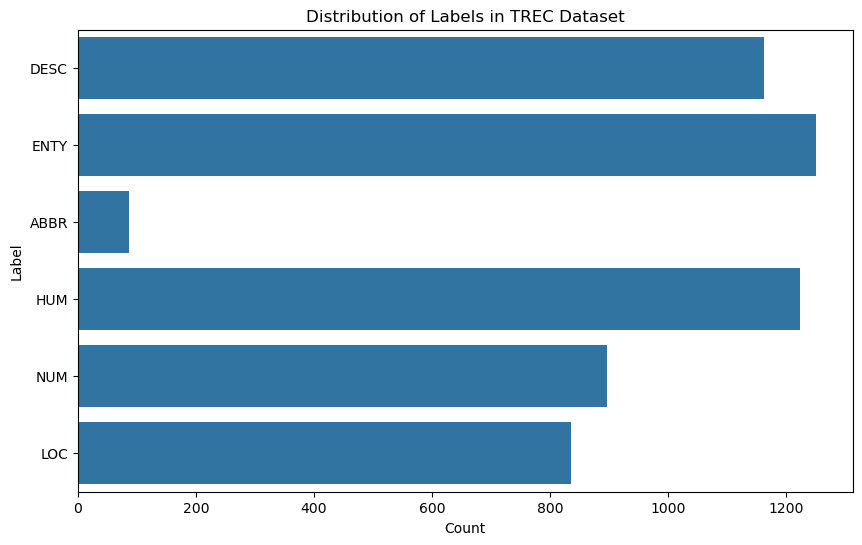

In [3]:
# Visualize the distribution of labels
plt.figure(figsize=(10, 6))
sns.countplot(y='label', data=train_df)
plt.title('Distribution of Labels in TREC Dataset')
plt.xlabel('Count')
plt.ylabel('Label')
plt.show()

## Text Length Analysis

Let's analyze the length of the text samples in the training dataset.

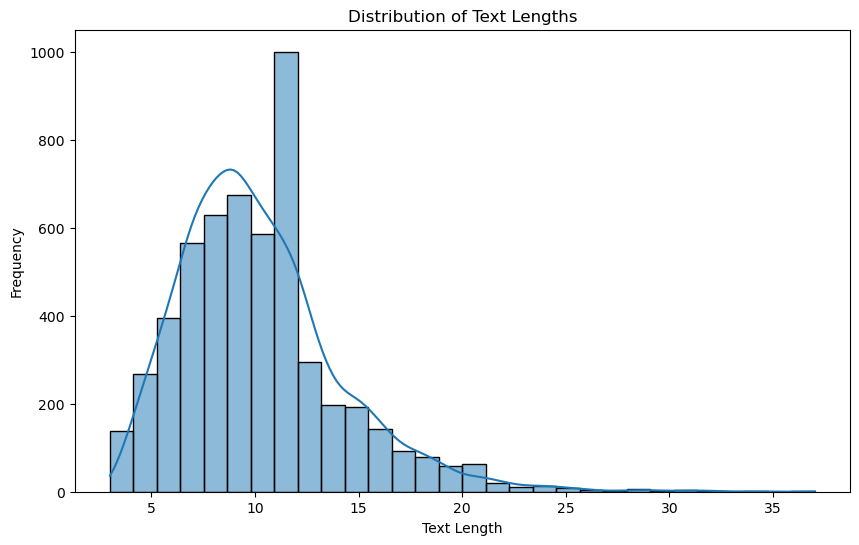

In [4]:
# Calculate text lengths
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))

# Visualize text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['text_length'], bins=30, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

## Next Steps

In the following sections, we will preprocess the data, create the RNN model, and set up the training loop.

Loading Word2Vec embeddings... (this may take a few minutes)
[==================================================] 100.0% 1662.8/1662.8MB downloaded
Word2Vec loaded successfully!

Total words in training data: 55635
Unique words in training data: 8678

Number of OOV words: 1541
Number of in-vocabulary words: 7137
OOV rate: 17.76%

Sample OOV words: ['ready-to-eat', 'anti-aids', 'rossner', 'left-handed', 'firehole', 'rosanna-dana', 'aldous', 'keck', 'sark', '19', 'sinatra', '1945', 'grenada', '21-27', 'humphrey', 'billingsgate', 'maddox', 'zadora', 'u.s', 'oceania']

OOV Analysis by Category:
Category  OOV Words  Total Unique Words  OOV Rate (%)
     HUM        511                3321         15.39
    ENTY        490                3371         14.54
    DESC        300                2599         11.54
     LOC        280                1962         14.27
     NUM        241                2096         11.50
    ABBR         39                 171         22.81


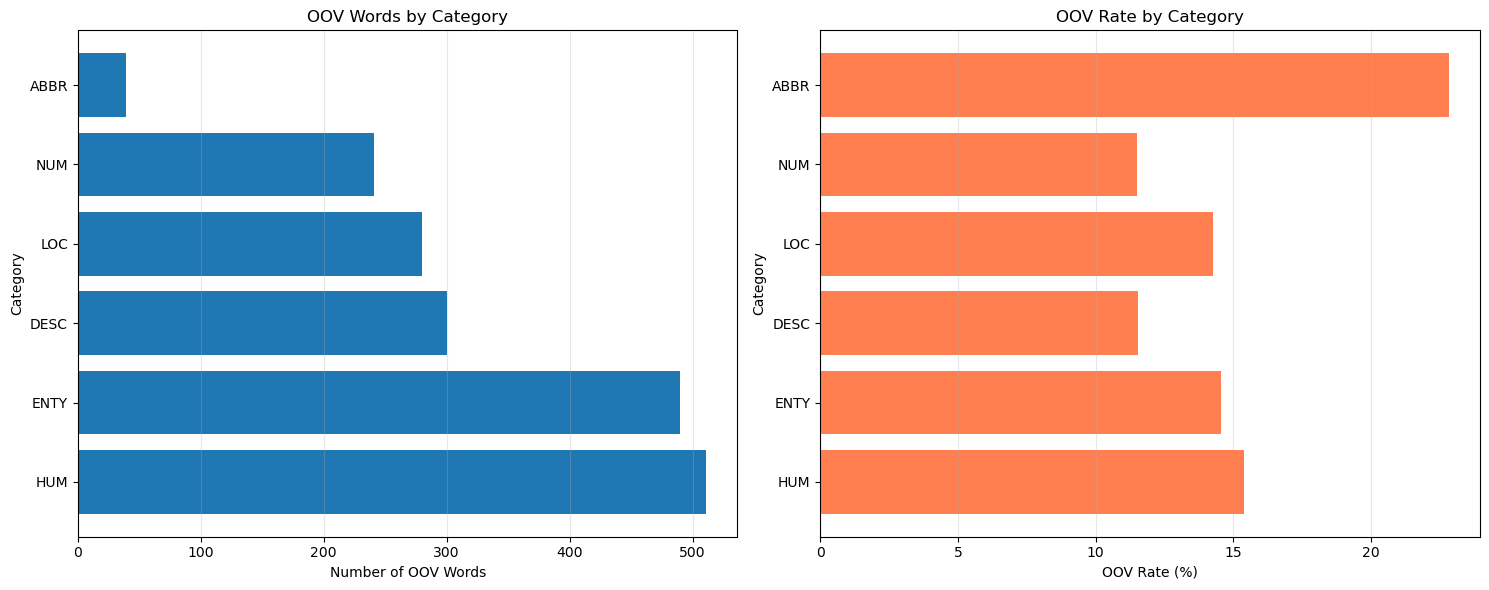

In [5]:
import gensim.downloader as api
from collections import Counter
import numpy as np

# Load pre-trained Word2Vec embeddings (Google News 300d)
print("Loading Word2Vec embeddings... (this may take a few minutes)")
word2vec_model = api.load('word2vec-google-news-300')
print("Word2Vec loaded successfully!")

# Alternative: Load GloVe embeddings
# word2vec_model = api.load('glove-wiki-gigaword-100')

# Tokenize and get vocabulary from training data
def tokenize_text(text):
    """Simple tokenization - split by whitespace and convert to lowercase"""
    return text.lower().split()

# Get all words from training data
all_words = []
for text in train_df['text']:
    all_words.extend(tokenize_text(text))

# Count word frequencies
word_freq = Counter(all_words)
unique_words = set(all_words)

print(f"\nTotal words in training data: {len(all_words)}")
print(f"Unique words in training data: {len(unique_words)}")

# Find OOV words
oov_words = []
iv_words = []  # in-vocabulary words

for word in unique_words:
    if word not in word2vec_model:
        oov_words.append(word)
    else:
        iv_words.append(word)

print(f"\nNumber of OOV words: {len(oov_words)}")
print(f"Number of in-vocabulary words: {len(iv_words)}")
print(f"OOV rate: {len(oov_words) / len(unique_words) * 100:.2f}%")

# Show some examples of OOV words
print(f"\nSample OOV words: {oov_words[:20]}")

# Analyze OOV words per topic category
def get_oov_for_category(df, category, word2vec_model):
    """Get OOV words for a specific category"""
    category_texts = df[df['label'] == category]['text']
    
    category_words = []
    for text in category_texts:
        category_words.extend(tokenize_text(text))
    
    unique_category_words = set(category_words)
    
    oov_category = [word for word in unique_category_words if word not in word2vec_model]
    
    return len(oov_category), len(unique_category_words)

# Calculate OOV for each category
categories = train_df['label'].unique()
oov_results = []

for category in categories:
    oov_count, total_unique = get_oov_for_category(train_df, category, word2vec_model)
    oov_rate = (oov_count / total_unique * 100) if total_unique > 0 else 0
    
    oov_results.append({
        'Category': category,
        'OOV Words': oov_count,
        'Total Unique Words': total_unique,
        'OOV Rate (%)': round(oov_rate, 2)
    })

# Create DataFrame and display results
oov_df = pd.DataFrame(oov_results)
oov_df = oov_df.sort_values('OOV Words', ascending=False)
print("\nOOV Analysis by Category:")
print(oov_df.to_string(index=False))

# Visualize OOV words by category
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: OOV word counts by category
axes[0].barh(oov_df['Category'], oov_df['OOV Words'])
axes[0].set_xlabel('Number of OOV Words')
axes[0].set_ylabel('Category')
axes[0].set_title('OOV Words by Category')
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: OOV rate by category
axes[1].barh(oov_df['Category'], oov_df['OOV Rate (%)'], color='coral')
axes[1].set_xlabel('OOV Rate (%)')
axes[1].set_ylabel('Category')
axes[1].set_title('OOV Rate by Category')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()